# Inf 573 projet


# Hongyu Zhou, Haojun Zhao

In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import time
import matplotlib.pyplot as plt
from PIL import Image

### Parameters

In [21]:
video_name="grandhall.mp4"
Root_directory="E:\\test\\"
video_path=Root_directory+video_name
output_path=Root_directory+video_name[:-4]+"\\outputImages\\"
annotated_image_path = Root_directory+ video_name[:-4] + "\\annotatedImages\\"
mask_video_name=Root_directory+video_name[:-4]+"_annotated.mp4"

model = tf.keras.models.load_model('./mask_detect_densenet.h5', compile=False)


#creat new feature
folder = os.path.exists(output_path)
if not folder:
    os.makedirs(output_path) 
folder = os.path.exists(annotated_image_path)
if not folder:
    os.makedirs(annotated_image_path) 
    

In [ ]:
detector=MTCNN()

## Video to images

In [35]:
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
fps =cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

i=0
while(cap.isOpened()):
    i=i+1
    ret, frame = cap.read()
    if ret==True:
        cv2.imwrite(output_path+str(i)+'.jpg',frame)
        print('image'+str(i)+" Ok")
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    else:
        break
cap.release()
cv2.destroyAllWindows()

image1 Ok
image2 Ok
image3 Ok
image4 Ok
image5 Ok
image6 Ok
image7 Ok
image8 Ok
image9 Ok
image10 Ok
image11 Ok
image12 Ok
image13 Ok
image14 Ok
image15 Ok
image16 Ok
image17 Ok
image18 Ok
image19 Ok
image20 Ok
image21 Ok
image22 Ok
image23 Ok
image24 Ok
image25 Ok
image26 Ok
image27 Ok
image28 Ok
image29 Ok
image30 Ok
image31 Ok
image32 Ok
image33 Ok
image34 Ok
image35 Ok
image36 Ok
image37 Ok
image38 Ok
image39 Ok
image40 Ok
image41 Ok
image42 Ok
image43 Ok
image44 Ok
image45 Ok
image46 Ok
image47 Ok
image48 Ok
image49 Ok
image50 Ok
image51 Ok
image52 Ok
image53 Ok
image54 Ok
image55 Ok
image56 Ok
image57 Ok
image58 Ok
image59 Ok
image60 Ok
image61 Ok
image62 Ok
image63 Ok
image64 Ok
image65 Ok
image66 Ok
image67 Ok
image68 Ok
image69 Ok
image70 Ok
image71 Ok
image72 Ok
image73 Ok
image74 Ok
image75 Ok
image76 Ok
image77 Ok
image78 Ok
image79 Ok
image80 Ok
image81 Ok
image82 Ok
image83 Ok
image84 Ok
image85 Ok
image86 Ok
image87 Ok
image88 Ok
image89 Ok
image90 Ok
image91 Ok
image92 

##  Function for distance estimation


In [3]:
f=26e-3
face_width=12e-2
verticle=True
if verticle:
    film_width=24e-3
else:
    film_width=36e-3

def cal_depth(box_width,img_width):
    return f*face_width/(box_width/img_width*film_width)

def cal_horizontal_dis(d1,d2,z1,z2):
    if z1>z2:
        tmp=d1;tmp2=z1
        d1=d2;d2=tmp
        z1=z2;z2=tmp2
    #suppose z1<z2
    if d1*d2<0:
        d1=abs(d1);d2=abs(d2)
        dis=(d1+d2)/f*z1+d2/f*(z2-z1)
    elif d1*d2>0:
        d1=abs(d1);d2=abs(d2)
        dis=d1/f*z1-d2/f*z2
    else:
        d1=abs(d1);d2=abs(d2)
        if d2==0:
            dis=d1/f*z1
        else:
            dis=d2/f*z2
    return dis

def distance_estimation(faces,width):
    face_width_pixels=[]
    faces_center=[]
    for face in faces:
        if face['confidence'] < 0.95:
            continue
        bounding_box=face['box']
        face_width_pixels.append(bounding_box[2])
        faces_center.append(bounding_box[0]+bounding_box[2]//2)
    dis=None
    if(len(face_width_pixels)==2):
        z1=cal_depth(face_width_pixels[0],width) #depth
        z2=cal_depth(face_width_pixels[1],width)
        d1=(faces_center[0]-width//2)/width*film_width  
        d2=(faces_center[1]-width//2)/width*film_width
#         print(d1,d2)
        h=cal_horizontal_dis(d1,d2,z1,z2)
        dis=np.sqrt(h**2+(z2-z1)**2)
#         print(z2-z1)
    return dis

## Image annotation

In [4]:
def detect_mask(name,estimation=False):
#     img=plt.imread(name)
    img=cv2.imread(name)
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    faces=detector.detect_faces(img_rgb)
    
    if estimation:
        dis=distance_estimation(faces,img.shape[1])
    else:
        dis=None

    for face in faces:  
        if face['confidence'] < 0.95:
            continue
        
        bounding_box=face['box']
        
        
        crop_img=img[bounding_box[1]:bounding_box[1]+bounding_box[3],bounding_box[0]:bounding_box[0]+bounding_box[2]]
        crop_img=cv2.resize(crop_img,(50,50))  #50,50
        crop_img=crop_img.reshape(-1,50,50,3)   # 1,50,50,3
        crop_img=tf.keras.utils.normalize(crop_img,axis=1)
        predict= model(crop_img)
        
        seuil =0.6
        if dis is not None:
            if dis > seuil:
                img=cv2.putText(img,f"Distance : {dis:.1f} > {seuil}  Safe", (0 , 30), cv2.FONT_HERSHEY_SIMPLEX,
                            1,(0,255,0),2 , cv2.LINE_AA,) #scale, color, thicknees
            else:
                img=cv2.putText(img,f"Distance : {dis:.1f} < {seuil}  Alarm", (0 , 30), cv2.FONT_HERSHEY_SIMPLEX,
                            1,(0,0,255),2 , cv2.LINE_AA,) #scale, color, thicknees
        
        if(predict[0][0] < predict[0][1]):       # [0,1] for mask
            img=cv2.rectangle(img,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,255,0),
                  2) # BGR, thickness
            img=cv2.putText(img,"mask", (bounding_box[0] , bounding_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                    1,(0,255,0),2 , cv2.LINE_AA,) #scale, color, thicknees
        else:
            img=cv2.rectangle(img,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,0,255),
                  2) # BGR, thickness
            img=cv2.putText(img,"No Mask", (bounding_box[0] , bounding_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                    1,(0,0,255),2 , cv2.LINE_AA,) #scale, color, thicknees
#     img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
#     img=cv2.resize(img,(img.shape[1]//2,img.shape[0]//2))
#     faces_moments.append(faces_center)

    return dis,img

In [14]:
ImagesNumber = len(list(os.listdir(output_path))) 

In [17]:
distance=[]
for i in range(1,1+ImagesNumber):#1+ImagesNumber
    name=output_path+str(i)+".jpg"
    estimation_distance=False
    d,img=detect_mask(name,estimation_distance)
    if d is not None:
        distance.append(d)
    cv2.imwrite(annotated_image_path+f'{i}'+'.jpg',img)
    print(f"Image {i} finished") 

Image 1 finished
Image 2 finished
Image 3 finished
Image 4 finished
Image 5 finished
Image 6 finished
Image 7 finished
Image 8 finished
Image 9 finished
Image 10 finished
Image 11 finished
Image 12 finished
Image 13 finished
Image 14 finished
Image 15 finished
Image 16 finished
Image 17 finished
Image 18 finished
Image 19 finished
Image 20 finished
Image 21 finished
Image 22 finished
Image 23 finished
Image 24 finished
Image 25 finished
Image 26 finished
Image 27 finished
Image 28 finished
Image 29 finished
Image 30 finished
Image 31 finished
Image 32 finished
Image 33 finished
Image 34 finished
Image 35 finished
Image 36 finished
Image 37 finished
Image 38 finished
Image 39 finished
Image 40 finished
Image 41 finished
Image 42 finished
Image 43 finished
Image 44 finished
Image 45 finished
Image 46 finished
Image 47 finished
Image 48 finished
Image 49 finished
Image 50 finished
Image 51 finished
Image 52 finished
Image 53 finished
Image 54 finished
Image 55 finished
Image 56 finished
I

Image 438 finished
Image 439 finished
Image 440 finished
Image 441 finished
Image 442 finished
Image 443 finished
Image 444 finished
Image 445 finished
Image 446 finished
Image 447 finished
Image 448 finished
Image 449 finished
Image 450 finished
Image 451 finished
Image 452 finished
Image 453 finished
Image 454 finished
Image 455 finished
Image 456 finished
Image 457 finished
Image 458 finished
Image 459 finished
Image 460 finished
Image 461 finished
Image 462 finished
Image 463 finished
Image 464 finished
Image 465 finished
Image 466 finished
Image 467 finished
Image 468 finished
Image 469 finished
Image 470 finished
Image 471 finished
Image 472 finished
Image 473 finished
Image 474 finished
Image 475 finished
Image 476 finished
Image 477 finished
Image 478 finished
Image 479 finished
Image 480 finished
Image 481 finished
Image 482 finished
Image 483 finished
Image 484 finished
Image 485 finished
Image 486 finished
Image 487 finished
Image 488 finished
Image 489 finished
Image 490 fi

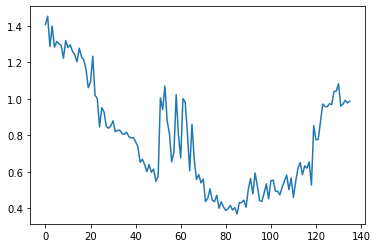

In [41]:
plt.plot(distance)

##  Image to Video

In [18]:
path = annotated_image_path


file_lst = os.listdir(path)#file name

filename=file_lst[0]
img = cv2.imread(path + filename)
w,h,_=img.shape

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')  # output is mp4

cap_fps = 30

# size of image
size = (h,w)
 

video = cv2.VideoWriter(mask_video_name, fourcc, cap_fps, size)
 
# read img

for i in range(1,1+ImagesNumber):
    name=annotated_image_path+f'{i}'+'.jpg'
    img = cv2.imread(name)
    video.write(img)

video.release()


## Computer camera

In [24]:
#cascade
def draw_cascade(img):
    
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face=face_cascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=4)
    
    if(len(face)>0):
        for bounding_box in face:
            crop_img=img[bounding_box[1]:bounding_box[1]+bounding_box[3],bounding_box[0]:bounding_box[0]+bounding_box[2]]
            crop_img=cv2.resize(crop_img,(50,50))  #50,50
            crop_img=crop_img.reshape(-1,50,50,3)   # 1,50,50,3
            crop_img=tf.keras.utils.normalize(crop_img,axis=1)
            predict= model(crop_img)


            if(predict[0][0] < predict[0][1]):       # [0,1] for mask
                cv2.rectangle(img,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0,255,0),
                      2) # BGR, thickness
                cv2.putText(img,"mask", (bounding_box[0] , bounding_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                        1,(0,255,0),2 , cv2.LINE_AA,) #scale, color, thicknees
            else:
                cv2.rectangle(img,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0,0,255),
                      2) # BGR, thickness
                cv2.putText(img,"No Mask", (bounding_box[0] , bounding_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                        1,(0,0,255),2 , cv2.LINE_AA,) #scale, color, thicknees

#     img=cv2.resize(img,(img.shape[1]//2,img.shape[0]//2))


    return img

In [25]:
def video_demo():
    capture = cv2.VideoCapture(0)  # computer camera
    while (True):
        #RGB not BGR

        ret, frame = capture.read()  # read camera
        img = cv2.flip(frame, 1)  # 
        
        img=draw_cascade(img)
        
        cv2.imshow("video", img )
        c = cv2.waitKey(50)
        if c == 27: #Esc 
            break
    capture.release()
    cv2.destroyAllWindows()

In [26]:
model = tf.keras.models.load_model('E:\\maskdataset\\mask_detect_densenet.h5', compile=False)
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [27]:
video_demo()